<a href="https://colab.research.google.com/github/teftef6220/Stable_Diffusion_in_Colab/blob/main/fine_tuning_modelhub_in_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Colab で動かすStable Diffusion (Fintuning Model Ver 2.1) 

How to use fintuning_modelhub     (fintuning_modelhub の使い方)



1.   コードの実行ボタンを順にクリックしていきましょう(ランタイム→すべてのセルを実行でもよい) 
2.   モデル選択の前まで実行したら，使用するモデル(AI)を選択して実行
3.   Generate (画像生成) にて Prompt などを調整して画像生成

画像はGoogleDrive の　/content/drive/MyDrive/fine_tuning_modelhub_output　に保存されます．画像は毎回異なる連番ファイル名で保存するため，基本的に上書きをされることはないです．
 不具合などありましたら teftef (@hanyingcl) まで


In [ ]:
#@title mount to drive (ドライブにマウント)
from google.colab import drive
drive.mount('/content/drive')

!nvidia-smi --query-gpu=name,memory.total,memory.free --format=csv,noheader

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Tesla T4, 15109 MiB, 1769 MiB


In [ ]:
!pip install --upgrade git+https://github.com/huggingface/diffusers.git transformers accelerate scipy
from diffusers import StableDiffusionPipeline
from diffusers import DDIMScheduler
from diffusers import DPMSolverMultistepScheduler
from diffusers import LMSDiscreteScheduler
from diffusers import PNDMScheduler
from diffusers import EulerDiscreteScheduler
from diffusers import EulerAncestralDiscreteScheduler
from PIL.PngImagePlugin import PngInfo
import torch

#@title makedir (親フォルダを作成)
import os
new_dir_path = '/content/drive/MyDrive/fine_tuning_modelhub_output'
os.makedirs(new_dir_path,exist_ok=True)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/huggingface/diffusers.git to /tmp/pip-req-build-lj3vcn9f
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/diffusers.git /tmp/pip-req-build-lj3vcn9f
  Resolved https://github.com/huggingface/diffusers.git to commit 9b37ed33b5fa09e594b38e4e6f7477beff3bd66a
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
#@title  モデル選択 (モデルを変更するときはここ以下を実行してください)
#@markdown モデル選択
model_name= "N-Diffusion-v0.1" #@param ["N-Diffusion-v0.1","plat-diffusion","8528-diffusion","yumekawa_diffusion_ver2.1"] {allow-input: false}
# model_id = "gsdf/counterfeit-v1.0" unet 実装待ち
# model_id = "RuminationDiffusion":"JosephusCheung/RuminationDiffusion"

model_dict={"N-Diffusion-v0.1":"Nikaidomasaki/N-Diffusion-v0.1",
            "plat-diffusion":"p1atdev/plat-diffusion",
            "8528-diffusion":"852wa/8528-diffusion",
            "yumekawa_diffusion_ver2.1":"teftef/yumekawa_diffusion_ver2.1"
            }
model_id = model_dict[model_name]

print("creating pipeline ...")
torch_dtype=torch.float16
if "yumekawa"in model_name :
  pipe = StableDiffusionPipeline.from_pretrained(model_id) 
else:
  pipe = StableDiffusionPipeline.from_pretrained(model_id, torch_dtype=torch.float16)
  print("safety_checker is disabled")
  pipe.safety_checker = lambda images, **kwargs: (images, False) 
pipe.enable_attention_slicing()
print(model_name)

pipe = pipe.to("cuda")

# path_index=model_id.find("/")

import os
sub_dir_path = os.path.join('/content/drive/MyDrive/fine_tuning_modelhub_output',model_name)
os.makedirs(sub_dir_path,exist_ok=True)

import glob
print(sub_dir_path)
image_num_count=len(glob.glob(sub_dir_path+'/*.png'))
print(image_num_count)

creating pipeline ...


Fetching 12 files:   0%|          | 0/12 [00:00<?, ?it/s]

yumekawa_diffusion_ver2.1
/content/drive/MyDrive/fine_tuning_modelhub_output/yumekawa_diffusion_ver2.1
8


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

saiving...output_0013~output_0016.png


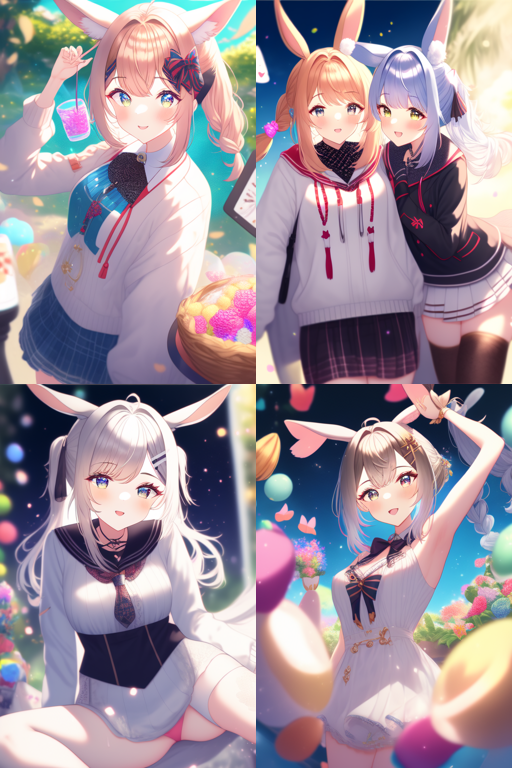

In [ ]:
#@title  同じモデル内で画像生成するときは、ここを逐一実行する(生成しまくると画像がどんどんたまっていくので注意)

#@markdown Prompt入力
prompt = "masterpiece," #@param {type : "string"}

#@markdown Negative Prompt入力
n_prompt = " low quality,bad hands,bad face," #@param {type : "string"}

#@markdown 縦の長さ(pix)入力 
height = "768" #@param[512,768,1024]

#@markdown 横の長さ(pix)入力 
width = "512" #@param[512,768,1024]

#@markdown Scale数入力
scale = 8 #@param{type:"number"}

#@markdown Step数入力
steps = 28 #@param{type:"number"}

#@markdown Random Seed (-1はランダムシード)
seed = 10 #@param{type:"number"}

#@markdown 生成枚数 (平方数が好ましい)
num = "4" #@param[1,4,9,16]

#@markdown scheduler選択
scheduler= "EulerAncestralDiscrete" #@param ["PNDM", "DDIM", "DPMSolverMultistep", "LMSDiscrete", "EulerDiscrete", "EulerAncestralDiscrete"] {allow-input: false}

#@markdown メタデータ書き込み  (こだわらない場合はデフォルト)
how_to_embed = "Both" #@param["Default","Steganography","Both"]

import random
import numpy as np
import cv2
from matplotlib import pyplot as plt
from IPython.display import Image,display_png
from PIL import Image

def save_img(img,path,pnginfo):
  """
  save img
  """
  img.save(path,pnginfo=pnginfo)

def steganography(prompt,n_prompt,seed,img,image_save_path,metadata):
  """
  Embed prompt,n_prompt,seed, using steganography
  """
  txt=prompt+" : "+n_prompt+" : "+" seed :"+str(seed)
  # print(txt)
  rgba_img = img.convert('RGBA')
  size = rgba_img.size
  result = Image.new('RGBA',size)
  result.paste(rgba_img, (0, 0))

  flag = False
  cnt = 0
  for y in range(size[1]):
      for x in range(size[0]):

          r,g,b,a = rgba_img.getpixel((x,y))
          r = r // 3 * 3
          g = g // 4 * 4
          b = b // 5 * 5

          get_ord = ord(txt[cnt])
          #Rの処理
          # 空白 . ? 数字 a ~ g
          if get_ord == 32 or get_ord == 46 or get_ord == 63 \
              or (get_ord >= 48 and get_ord <= 57) \
              or (get_ord >= 97 and get_ord <= 103):
              r += 1
          # h ~ z or end(!)
          elif (get_ord >= 104 and get_ord <= 122) or get_ord == 33:
              r += 2
          #Gの処理
          # 2 ~ 6 m ~ q
          if (get_ord >= 50 and get_ord <= 54) \
              or (get_ord >= 109 and get_ord <= 113):
              g += 1
          # 7 ~ 9 a ~ b r ~ v
          elif (get_ord >= 55 and get_ord <= 57) \
              or get_ord == 97 or get_ord == 98 \
              or (get_ord >= 114 and get_ord <= 118):
              g += 2
          # c ~ g w ~ z
          elif (get_ord >= 99 and get_ord <= 103) \
              or (get_ord >= 119 and get_ord <= 122) \
              or get_ord == 33:
              g += 3
          #Bの処理
          if r % 3 == 1:
              # .
              if get_ord == 46: b += 1
              # ?
              elif get_ord == 63:b += 2
              # 数字
              elif (get_ord >= 48 and get_ord <= 57):
                  b += (get_ord - 45) % 5
              # a ~ g
              elif (get_ord >= 97 and get_ord <= 103):
                  b += (get_ord - 94) % 5
          elif r % 3 == 2:
              # h ~ z
              if get_ord >= 104 and get_ord <= 122:
                  b += (get_ord - 104) % 5
              # end(!)
              elif  get_ord == 33:
                  b += 4
          result.putpixel((x,y),(r,g,b,a))
          #終了処理
          if cnt == len(txt) - 1 or (r % 3 == 2 and g % 4 == 3 and b % 5 == 4):
              flag = True
              break
          if cnt < len(txt) - 1:
              cnt += 1
      if flag:
          break

  #画像の保存
  save_img(result,image_save_path,metadata)


def torch_fix_seed(seed=42):
    # Python random
    random.seed(seed)
    # Numpy
    np.random.seed(seed)
    # Pytorch
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.use_deterministic_algorithms = True


# if(seed != -1):
#   torch_fix_seed(seed=seed)
# else:
#     torch.backends.cudnn.deterministic = False
#     torch.use_deterministic_algorithms = False

torch.backends.cudnn.deterministic = False
torch.use_deterministic_algorithms = False

##scheduler

if(scheduler == "PNDM"):
  pipe.scheduler = PNDMScheduler.from_config(pipe.scheduler.config)
elif(scheduler == "DDIM"):
  pipe.scheduler = DDIMScheduler.from_config(pipe.scheduler.config)
elif(scheduler == "DPMSolverMultistep"):
  pipe.scheduler = DPMSolverMultistepScheduler.from_config(pipe.scheduler.config)
elif(scheduler == "LMSDiscrete"):
  pipe.scheduler = LMSDiscreteScheduler.from_config(pipe.scheduler.config)
elif(scheduler == "EulerDiscrete"):
  pipe.scheduler = EulerDiscreteScheduler.from_config(pipe.scheduler.config)
elif(scheduler == "EulerAncestralDiscrete"):
  pipe.scheduler = EulerAncestralDiscreteScheduler.from_config(pipe.scheduler.config)

img_num=int(num)
images=[]
pm=1
for num in range(img_num):
  if seed == -1:
    seed = random.randrange(0, 4294967295, 1)
  generator = torch.Generator("cuda").manual_seed(seed)
  tmp_img=pipe(prompt, negative_prompt=n_prompt, height=int(height), width=int(width),guidance_scale=scale, num_inference_steps=steps,).images[0]
  image_num_count+=1
  image_save_path=sub_dir_path+"/output_"+'{0:04d}'.format(image_num_count)+".png"

  if how_to_embed == "Default":
      metadata = PngInfo()
      metadata.add_text("prompt",(prompt))
      metadata.add_text("n_prompt",(n_prompt))
      metadata.add_text("seed",(str(seed)))
      save_img(tmp_img,image_save_path,metadata)
      # tmp_img.save(sub_dir_path+"/output_"+'{0:04d}'.format(image_num_count)+".png",pnginfo=metadata)
  elif how_to_embed == "Steganography" : 
      metadata=None
      steganography(prompt,n_prompt,seed,tmp_img,image_save_path,metadata)
  else:
      metadata = PngInfo()
      metadata.add_text("prompt",(prompt))
      metadata.add_text("n_prompt",(n_prompt))
      metadata.add_text("seed",(str(seed)))
      steganography(prompt,n_prompt,seed,tmp_img,image_save_path,metadata)

  images.append(tmp_img)

#make_image_tile
def image_grid(imgs, rows, cols):
    assert len(imgs) == rows*cols

    w, h = imgs[0].size
    w,h=w//2,h//2
    grid = Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size

    for i, img in enumerate(imgs):
        img = img.resize((w, h))
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

# print(images)
print("saiving..."+"output_"+'{0:04d}'.format(int(image_num_count-int(num)))+"~"+"output_"+'{0:04d}'.format(int(image_num_count))+".png")

grid = image_grid(images, rows=int(np.sqrt(img_num)), cols=int(np.sqrt(img_num)))
#show img tile
grid

# ステガノグラフィ解析

In [ ]:
#@title  ファイル番号を入力 File Number (00～ではなく自然数で(Use natural Number))
from PIL import Image
#@markdown ファイル番号数入力
file_num = 13 #@param{type:"number"}

# img = Image.open(sys.argv[1])
img = Image.open(sub_dir_path+"/output_"+str(file_num).zfill(4)+".png")

print(type(img))
rgba_img = img.convert('RGBA')
size = rgba_img.size

flag = False
cnt = 0
for y in range(size[1]):
    for x in range(size[0]):

        r,g,b,a = rgba_img.getpixel((x,y))
        r = r % 3
        g = g % 4
        b = b % 5
        if r == 0:
            print(" ", end="")
        elif r == 1:
            if g == 0:
                if b == 0:
                    print(" ", end="")
                elif b == 1:
                    print(".", end="")
                elif b == 2:
                    print("?", end="")
                elif b == 3:
                    print("0", end="")
                elif b == 4:
                    print("1", end="")
            if g == 1:
                if b == 0:
                    print("2", end="")
                elif b == 1:
                    print("3", end="")
                elif b == 2:
                    print("4", end="")
                elif b == 3:
                    print("5", end="")
                elif b == 4:
                    print("6", end="")
            if g == 2:
                if b == 0:
                    print("7", end="")
                elif b == 1:
                    print("8", end="")
                elif b == 2:
                    print("9", end="")
                elif b == 3:
                    print("a", end="")
                elif b == 4:
                    print("b", end="")
            if g == 3:
                if b == 0:
                    print("c", end="")
                elif b == 1:
                    print("d", end="")
                elif b == 2:
                    print("e", end="")
                elif b == 3:
                    print("f", end="")
                elif b == 4:
                    print("g", end="")
        elif r == 2:
            if g == 0:
                if b == 0:
                    print("h", end="")
                elif b == 1:
                    print("i", end="")
                elif b == 2:
                    print("j", end="")
                elif b == 3:
                    print("k", end="")
                elif b == 4:
                    print("l", end="")
            if g == 1:
                if b == 0:
                    print("m", end="")
                elif b == 1:
                    print("n", end="")
                elif b == 2:
                    print("o", end="")
                elif b == 3:
                    print("p", end="")
                elif b == 4:
                    print("q", end="")
            if g == 2:
                if b == 0:
                    print("r", end="")
                elif b == 1:
                    print("s", end="")
                elif b == 2:
                    print("t", end="")
                elif b == 3:
                    print("u", end="")
                elif b == 4:
                    print("v", end="")
            if g == 3:
                if b == 0:
                    print("w", end="")
                elif b == 1:
                    print("x", end="")
                elif b == 2:
                    print("y", end="")
                elif b == 3:
                    print("z", end="")
                elif b == 4:
                    pass

        #終了処理
        if r == 2 and g == 3 and b == 4:
            flag = True
            print(" ")
            break
    if flag:
        break

<class 'PIL.PngImagePlugin.PngImageFile'>
masterpiece     low quality bad hands bad face     seed  10.u y . am y l 


#メタデータ解析

In [ ]:
#@title  ファイル番号を入力 File Number (00～ではなく自然数で(Use natural Number))

#@markdown ファイル番号数入力
file_num = 13 #@param{type:"number"}

import sys
from PIL import Image
from PIL.PngImagePlugin import PngInfo

# img = Image.open(sys.argv[1])
img = Image.open(sub_dir_path+"/output_"+str(file_num).zfill(4)+".png")
# print(img.text['prompt'],img.text['n_prompt'],img.text['seed'])
print("Prompt: ",img.text['prompt'])
print("Negative Prompt: ",img.text['n_prompt'])
print("seedt: ",img.text['seed'])

Prompt:  masterpiece,
Negative Prompt:   low quality,bad hands,bad face,
seedt:  10
